In [1]:
library(tidyverse) #Use required packages
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
df_data <- read_csv("framingham_data.csv") # Read in data
df_data %>% summary # Summarize Data


── Column specification ────────────────────────────────────────────────────────
cols(
  currentSmoker = col_double(),
  sysBP = col_double()
)




 currentSmoker      sysBP      
 Min.   :0.00   Min.   : 90.0  
 1st Qu.:0.00   1st Qu.:118.0  
 Median :0.00   Median :131.8  
 Mean   :0.25   Mean   :134.9  
 3rd Qu.:0.25   3rd Qu.:148.0  
 Max.   :1.00   Max.   :215.0  

In [36]:
df_data$index <- seq(nrow(df_data)) # Add an index column

#Create a sample variance function to ensure proper calculation
sample_variance <- function(x, sampling = TRUE){
    if (sampling == TRUE){
        sum((x - mean(x))^2) / (length(x) - 1)
    } else if(sampling == FALSE) {
        sum((x - mean(x))^2) / (length(x))
    }
}
#Create pooled sample variance function 
f_pooled_variance <- function(x, y){
    ((length(x) - 1) * sample_variance(x) + 
     (length(y) - 1) * sample_variance(y)) / 
    (length(x) + length(y) - 2)
}

df_data %>% summary # Summarize Data

#Split data based on smoking status
df_smoker <- df_data %>% filter(currentSmoker == 1)
df_nonsmoker <- df_data %>% filter(currentSmoker == 0)

 currentSmoker      sysBP           index       
 Min.   :0.00   Min.   : 90.0   Min.   :  1.00  
 1st Qu.:0.00   1st Qu.:118.0   1st Qu.: 75.75  
 Median :0.00   Median :131.8   Median :150.50  
 Mean   :0.25   Mean   :134.9   Mean   :150.50  
 3rd Qu.:0.25   3rd Qu.:148.0   3rd Qu.:225.25  
 Max.   :1.00   Max.   :215.0   Max.   :300.00  

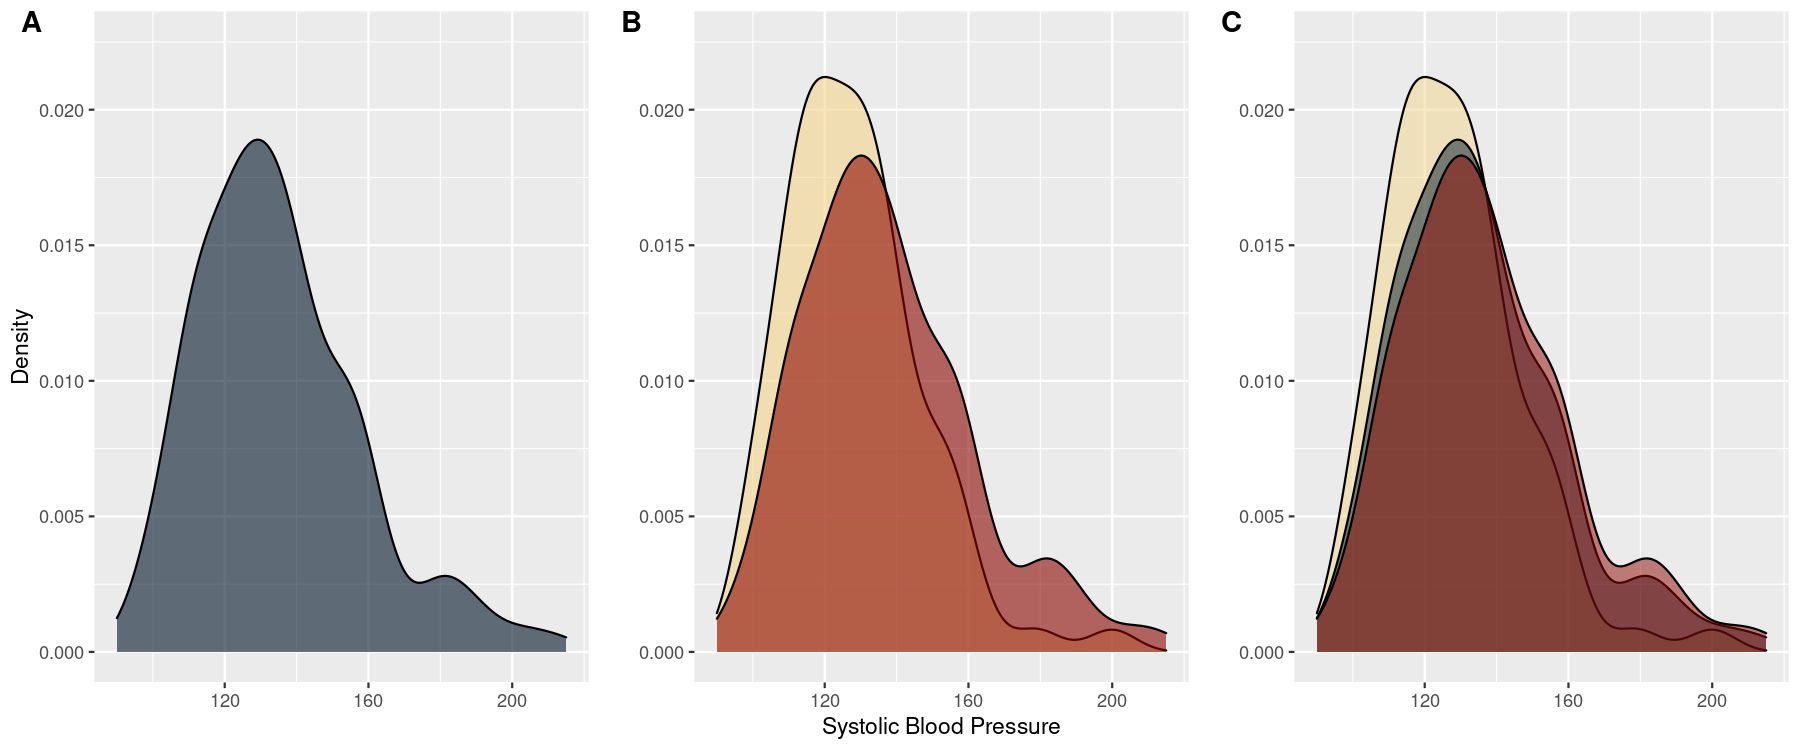

In [4]:
#Plot data

library(cowplot)
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 150)

plot_colors <- c("#001427","#708d81","#f4d58d","#bf0603","#8d0801")
#plot_colors <- c("#f04b00","#009b00","#1eb4aa","#f7f6f2","#202020")

y_limits <- c(0, 0.0225)

total_data <- ggplot(df_data) + geom_density(aes(sysBP), 
                                             fill = plot_colors[1],
                                             alpha = 0.6) +
                       ylim(y_limits) + ylab("Density") + xlab("")

sep_data <- ggplot() + geom_density(data = df_smoker, aes(sysBP), 
                                    fill = plot_colors[3], alpha = 0.6) + 
                       geom_density(data = df_nonsmoker, aes(sysBP), 
                                    fill = plot_colors[5], alpha = 0.6) +
                       ylim(y_limits) + ylab("") + xlab("Systolic Blood Pressure")

plot_3 <- ggplot() + geom_density(data = df_smoker, aes(sysBP), 
                                    fill = plot_colors[3], alpha = 0.5) + 
                       geom_density(data = df_data, aes(sysBP), 
                                    fill = plot_colors[1], alpha = 0.5) +
                       geom_density(data = df_nonsmoker, aes(sysBP), 
                                    fill = plot_colors[5], alpha = 0.5) +
                       ylim(y_limits) + ylab("") + xlab("")

plot_grid(total_data, sep_data, plot_3, align = 'vh', 
          hjust = -1,nrow = 1, ncol = 3, labels = c("A", "B", "C"))

In [5]:
alpha <- 0.05

mu_smoker <- mean(df_smoker$sysBP)
var_smoker <- sample_variance(df_smoker$sysBP)
n_smoker <- length(df_smoker$sysBP)

mu_nonsmoker <- mean(df_nonsmoker$sysBP)
var_nonsmoker <- sample_variance(df_nonsmoker$sysBP)
n_nonsmoker <- length(df_nonsmoker$sysBP)

dof <- (n_smoker + n_nonsmoker - 2)

p_sample_var <- f_pooled_variance(df_smoker$sysBP, 
                                  df_nonsmoker$sysBP)


t_obs <- (mu_smoker - mu_nonsmoker) / (sqrt(p_sample_var/n_smoker + p_sample_var/n_nonsmoker))

t_stat <- qt(alpha / 2, dof)

p_value_obs <- dt(t_obs, dof)

print(p_sample_var)

print(t_obs)

print(p_value_obs)

print(t_stat)

print(c(var_smoker, var_nonsmoker))

[1] 510.0137
[1] -3.041308
[1] 0.00412984
[1] -1.967957
[1] 352.2117 562.1447


In [6]:
set.seed(1)

alpha <- 0.05

test_function <- function (x, y, pooled = FALSE){
    
    #sample1 <- sample(x, size = length(x), replace = TRUE)#Bootstrap from first data frame
    #sample2 <- sample(y, size = length(y), replace = TRUE)#Bootstrap from second data frame
    sample1 <- x
    sample2 <- y
    
    dof <- length(x) + length(y) - 2 #Determine degrees of freedom
    
    #calculate the mean and variance of the two bootstrap sets
    mu_1 <- mean(sample1)
    var_1 <- sample_variance(sample1, sampling = FALSE)
    
    mu_2 <- mean(sample2)
    var_2 <- sample_variance(sample2, sampling = FALSE)
    
    #Calculate the pooled sample variance
    pooled_sample <- ((length(x) - 1) * var_1 + (length(y) - 1) * var_2) / (length(x) + length(y) - 2)
    
    #calulate the observed t statistic
    if (pooled == TRUE){
        ttest <- (mu_1 - mu_2) / (sqrt(pooled_sample/length(x) + pooled_sample/length(y)))
        } else {
        ttest <- (mu_1 - mu_2) / (sqrt(var_1/length(x) + var_2/length(y)))
    }
    
    #Determine whether or not the null hypothesis can be rejected (1 = rejected, 0 = not rejected)
    verdict <- !between(ttest, qt(alpha / 2, dof), qt(1 - alpha / 2, dof))
    
    #Return calculated values
    return(c(mu_1, var_1, mu_2, var_2, ttest, pooled_sample, verdict))
}

In [7]:
set.seed(1980)

sim_data_results <- rep(0, 7)

for (i in seq(1, 1000)){
    #Run the boot strap a 1000 times and store the results in a matrix
    sim_data_results <- rbind(sim_data_results, test_function(df_nonsmoker$sysBP, df_smoker$sysBP))
}

nrow(sim_data_results)

[1] 1001

In [8]:
#Move data into dataframe for easier processing 

df_sim_data <- data.frame(sim_data_results[2:nrow(sim_data_results),]) 
                          
colnames(df_sim_data) = c("Mean Smoker", "Variance Smoker", "Mean NonSmoker", "Variance NonSmoker", 
                          "T statistic", "Pooled Sample Variance", "Null Reject")

In [9]:
#Calculate the number of scenarios where the null was rejected 
sum(df_sim_data$'Null Reject')

[1] 1000

In [10]:
df_sim_data %>% head

,Mean Smoker,Variance Smoker,Mean NonSmoker,Variance NonSmoker,T statistic,Pooled Sample Variance,Null Reject
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X,137.2244,559.6463,128.0667,347.5156,3.431816,506.9695,1
X.1,137.2244,559.6463,128.0667,347.5156,3.431816,506.9695,1
X.2,137.2244,559.6463,128.0667,347.5156,3.431816,506.9695,1
X.3,137.2244,559.6463,128.0667,347.5156,3.431816,506.9695,1
X.4,137.2244,559.6463,128.0667,347.5156,3.431816,506.9695,1
X.5,137.2244,559.6463,128.0667,347.5156,3.431816,506.9695,1


In [11]:
str(df_sim_data)

'data.frame':	1000 obs. of  7 variables:
 $ Mean Smoker           : num  137 137 137 137 137 ...
 $ Variance Smoker       : num  560 560 560 560 560 ...
 $ Mean NonSmoker        : num  128 128 128 128 128 ...
 $ Variance NonSmoker    : num  348 348 348 348 348 ...
 $ T statistic           : num  3.43 3.43 3.43 3.43 3.43 ...
 $ Pooled Sample Variance: num  507 507 507 507 507 ...
 $ Null Reject           : num  1 1 1 1 1 1 1 1 1 1 ...


In [12]:
sample_variance <- function(x){
    sum((x - mean(x))^2) / (length(x) - 1)
}

sample_variance(df_data$sysBP)
var(df_data$sysBP)

[1] 524.0852

[1] 524.0852

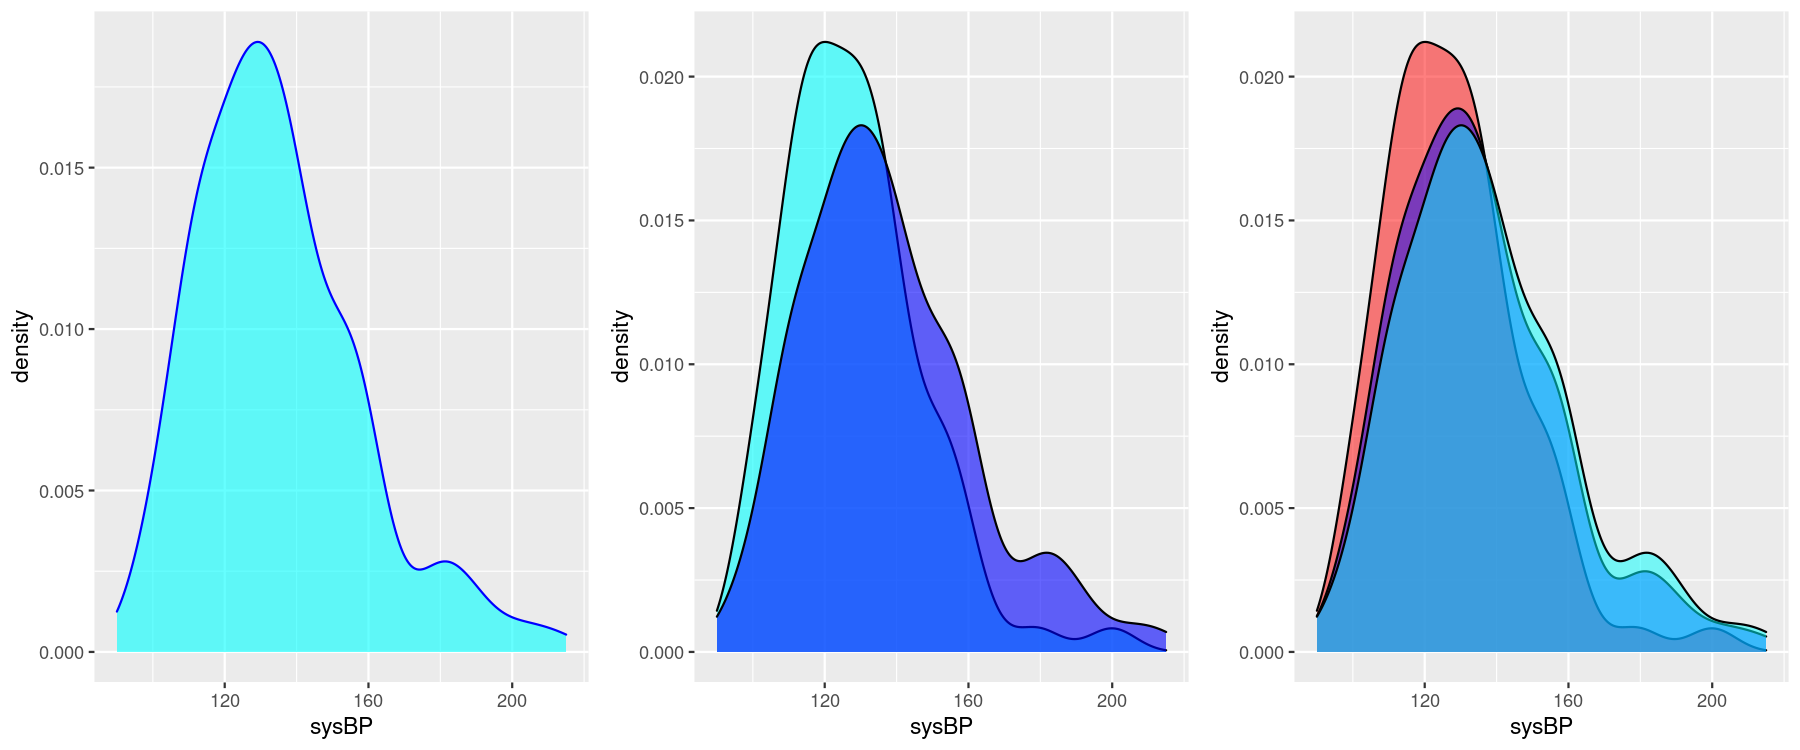

In [305]:
library(cowplot)
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 150)

total_data <- ggplot(df_data) + geom_density(aes(sysBP), 
                                             fill = "cyan",
                                             color = "blue",
                                             alpha = 0.6)

sep_data <- ggplot() + geom_density(data = df_smoker, aes(sysBP), 
                                    fill = "cyan", alpha = 0.6) + 
                       geom_density(data = df_nonsmoker, aes(sysBP), 
                                    fill = "blue", alpha = 0.6)

plot_3 <- ggplot() + geom_density(data = df_smoker, aes(sysBP), 
                                    fill = "red", alpha = 0.5) + 
                       geom_density(data = df_data, aes(sysBP), 
                                    fill = "blue", alpha = 0.5) +
                       geom_density(data = df_nonsmoker, aes(sysBP), 
                                    fill = "cyan", alpha = 0.5)

plot_grid(total_data, sep_data, plot_3, align = 'vh', 
          hjust = -1,nrow = 1, ncol = 3)

In [14]:
library(e1071)
sd(df_data$sysBP)
mean(df_data$sysBP)
kurtosis(df_data$sysBP)
skewness(df_data$sysBP)

[1] 22.89291

[1] 134.935

[1] 0.8123606

[1] 0.8797915

In [15]:
qchisq(0.95, 3)

[1] 7.814728

In [16]:
satterth <- function(s1, s2, n1, n2){
    term1 <- s1/n1
    term2 <- s2/n2
    nu <- (term1 + term2)^2 / ((term1/(n1 - 1)) + (term2/(n2 - 1)))
    return(floor(nu))
}

In [17]:
satterth(var_smoker, var_nonsmoker, n_smoker, n_nonsmoker)

[1] 693

In [18]:
dof_1 <- (n_smoker + n_nonsmoker - 2)

p_sample_var_1 <- f_pooled_variance(df_smoker$sysBP, 
                                    df_nonsmoker$sysBP)


t_obs_1 <- (mu_smoker - mu_nonsmoker) / (sqrt(p_sample_var_1) * sqrt(1/n_smoker + 1/n_nonsmoker))

t_stat_1 <- qt(alpha / 2, dof_1)

p_value_obs_1 <- dt(t_obs_1, dof_1)

#Two Sample T-test - Difference Variance Sample Variance - P-value

dof_2 <- satterth(var_smoker, var_nonsmoker, n_smoker, n_nonsmoker)

t_obs_2 <- (mu_smoker - mu_nonsmoker) / (sqrt(var_nonsmoker/n_smoker + var_nonsmoker/n_nonsmoker))

t_stat_2 <- qt(alpha / 2, dof_2)

p_value_obs_2 <- dt(t_obs_2, dof_2)

In [19]:
# Confidence Limits

diff_mu <- mu_smoker - mu_nonsmoker

#Pooled Sample varince

CI_pooled <- t_stat_1 * (sqrt(p_sample_var_1/n_smoker + p_sample_var_1/n_nonsmoker))

#Non pooled Sample varince

CI_nonpooled <- t_stat_2 * (sqrt(var_nonsmoker/n_smoker + var_nonsmoker/n_nonsmoker))

In [20]:
CI_pooled
CI_nonpooled

[1] -5.925775

[1] -6.206833

In [21]:
round(c(diff_mu + CI_pooled, diff_mu - CI_pooled), 2)

round(c(diff_mu + CI_nonpooled, diff_mu - CI_nonpooled), 2)

[1] -15.08  -3.23

[1] -15.36  -2.95

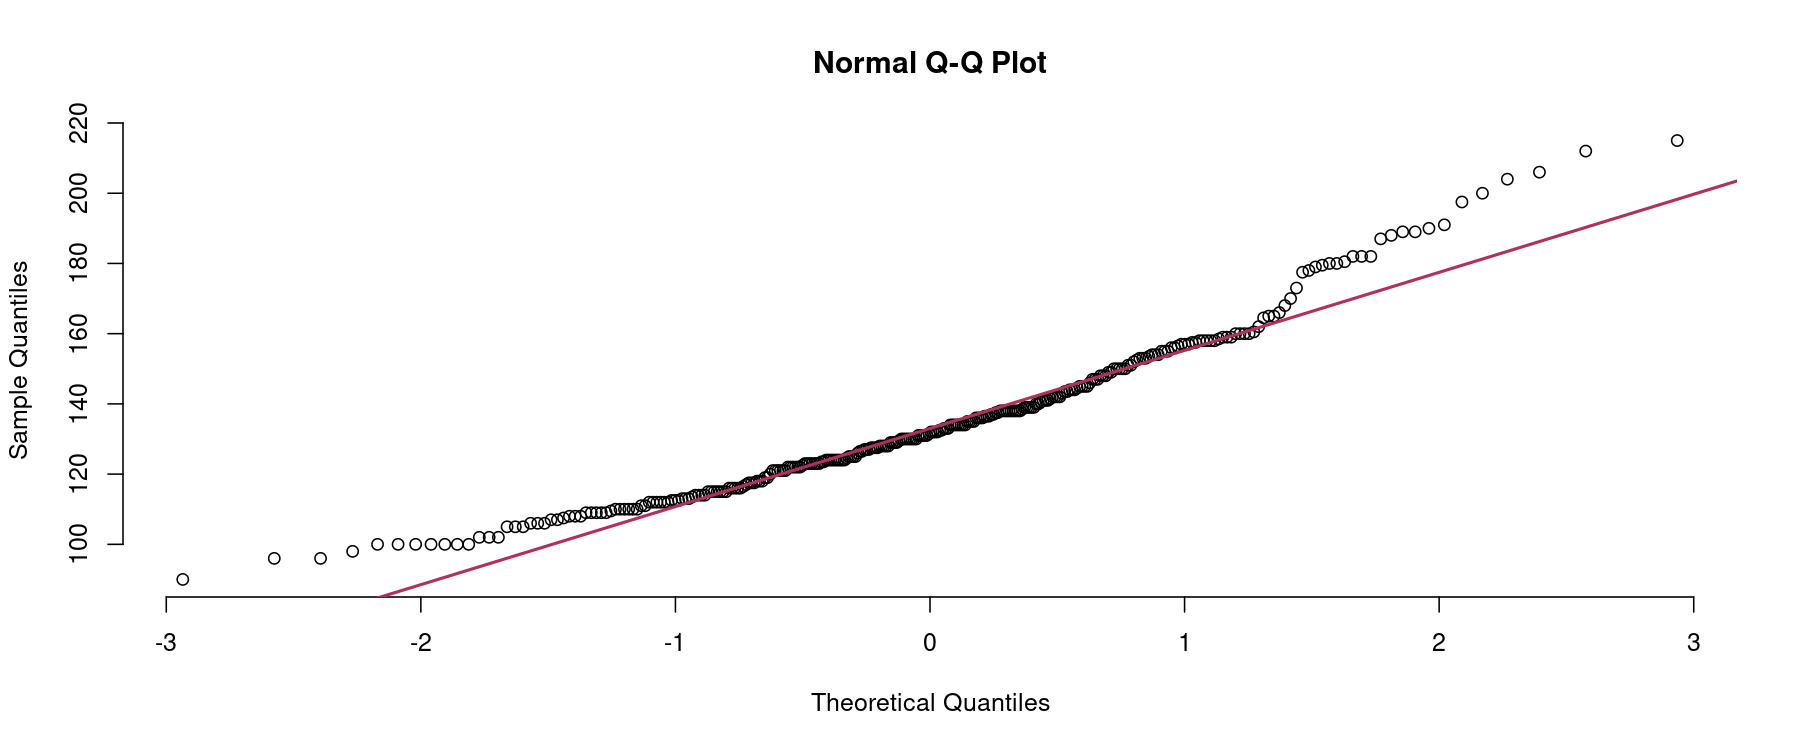

In [22]:
# Normality
qqnorm(df_data$sysBP, pch = 1, frame = FALSE)
qqline(df_data$sysBP, col = "maroon", lwd = 2)

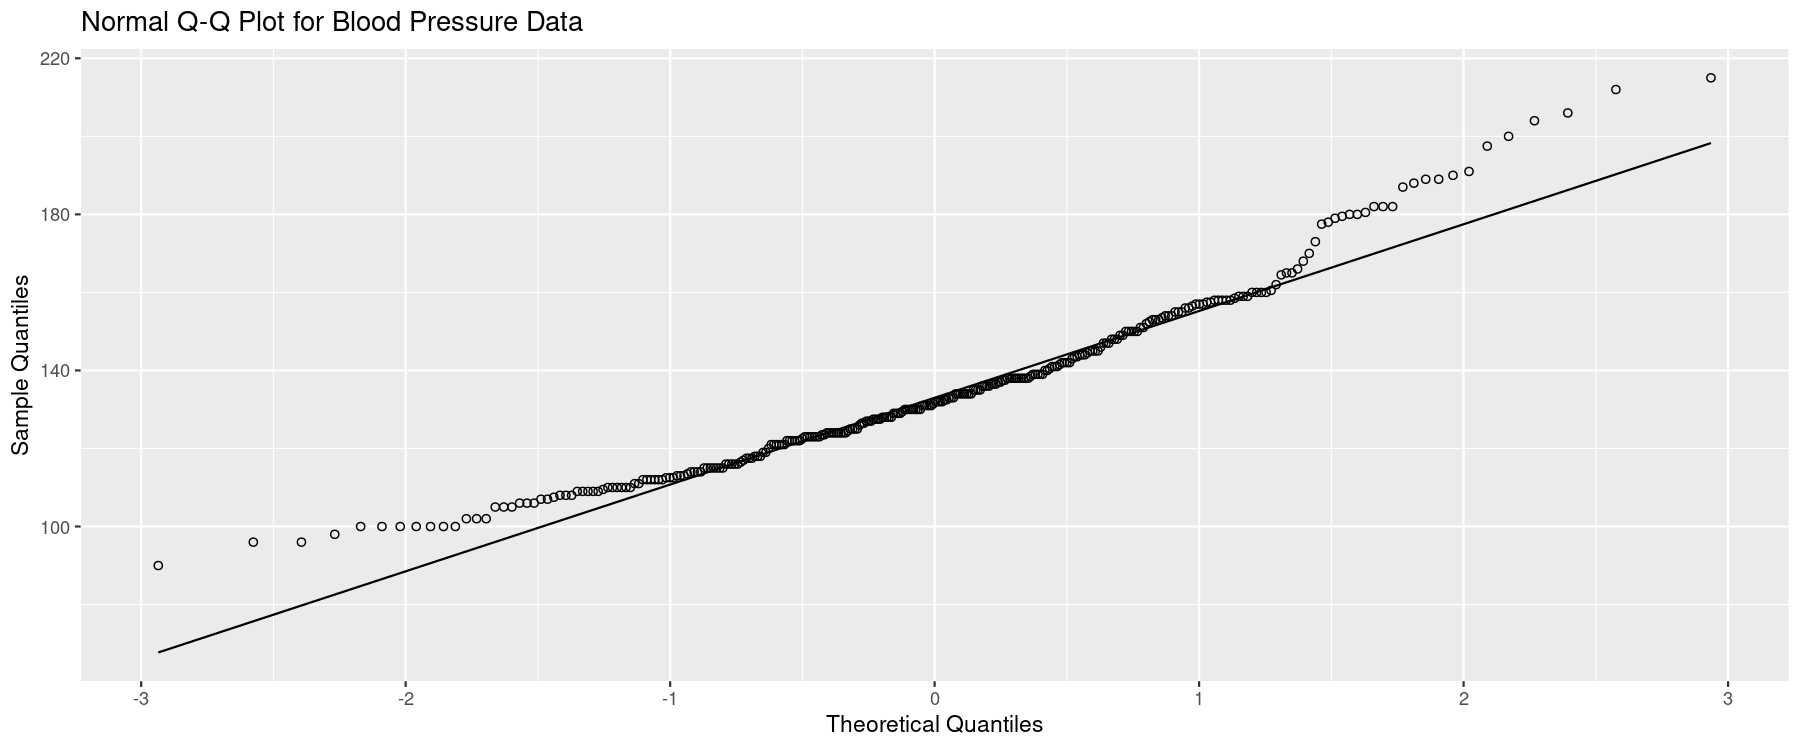

In [44]:
data_qqplot <- 
ggplot(df_data, aes(sample = sysBP)) + 
stat_qq(shape = 1) + stat_qq_line() + 
ggtitle("Normal Q-Q Plot for Blood Pressure Data") + 
xlab("Theoretical Quantiles") +
ylab("Sample Quantiles")

data_qqplot

In [24]:
b1 <- mean(df_data$sysBP - mean(df_data$sysBP))^3 / sqrt(sample_variance(df_data$sysBP))^3

In [25]:
b1

[1] -9.775034e-49

mean(df_data$sysBP - mean(df_data$sysBP))^3

In [26]:
mean((df_data$sysBP - mean(df_data$sysBP))^3) / sqrt(sample_variance(df_data$sysBP))^3

[1] 0.8797915

In [27]:
mean((df_data$sysBP - mean(df_data$sysBP))^4) / sqrt(sample_variance(df_data$sysBP))^4

[1] 3.812361

In [28]:
kurtosis(df_data$sysBP)
skewness(df_data$sysBP)

[1] 0.8123606

[1] 0.8797915

[1] -0.009905921

[1] 2.995056

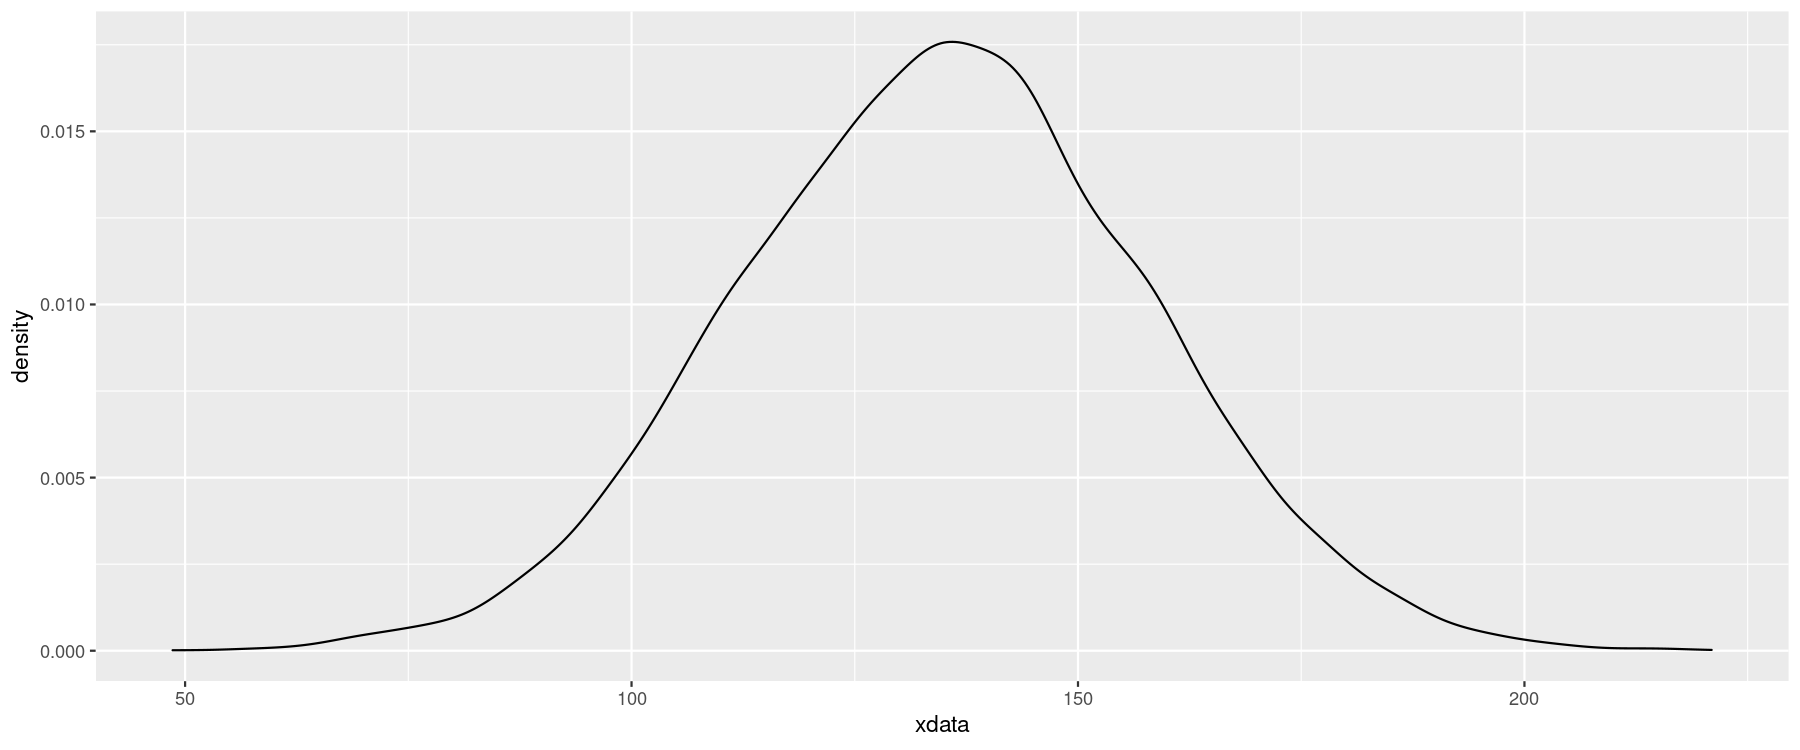

In [29]:
df_test <- data.frame(rnorm(10000, mean(df_data$sysBP), sqrt(sample_variance(df_data$sysBP))))

colnames(df_test) <- "xdata"

ggplot(data = df_test) + geom_density(aes(xdata))

mean((df_test$xdata - mean(df_test$xdata))^3) / sqrt(sample_variance(df_test$xdata))^3

mean((df_test$xdata - mean(df_test$xdata))^4) / sqrt(sample_variance(df_test$xdata))^4

In [30]:
kurt_function <- function(x){
    mean((x - mean(x))^4) / sqrt(sample_variance(x))^4
}

skew_function <- function(x){
    mean((x - mean(x))^3) / sqrt(sample_variance(x))^3
}

skew_function(df_test$xdata)
kurt_function(df_test$xdata)

[1] -0.009905921

[1] 2.995056

In [31]:
skew_function(df_data$sysBP)
kurt_function(df_data$sysBP)

[1] 0.8797915

[1] 3.812361

In [32]:
IQR <- as.numeric(quantile(df_data$sysBP, probs = 0.75)) - 
       as.numeric(quantile(df_data$sysBP, probs = 0.25))

MAD <- median(abs(df_data$sysBP - median(df_data$sysBP)))

In [33]:
sqrt(sample_variance(df_data$sysBP))
IQR/1.35
MAD/0.675

[1] 22.89291

[1] 22.22222

[1] 21.48148

In [335]:
set.seed(1)

alpha <- 0.05

test_function <- function (x, y, pooled = FALSE){

    mu_1 <- mean(x)
    var_1 <- sample_variance(x, sampling = TRUE)
    
    mu_2 <- mean(y)
    var_2 <- sample_variance(y, sampling = TRUE)
    
    #Calculate the pooled sample variance
    pooled_sample <- ((length(x) - 1) * var_1 + (length(y) - 1) * var_2) / (length(x) + length(y) - 2)
    
    #calulate the observed t statistic
    if (pooled == TRUE){
        
        cal_sigma <- (sqrt(pooled_sample/length(x) + pooled_sample/length(y)))
        
        ttest <- (mu_1 - mu_2) / cal_sigma
        dof <- length(x) + length(y) - 2 #Determine degrees of freedom
        
        } else {
        
        cal_sigma <- (sqrt(var_1/length(x) + var_2/length(y)))
        
        ttest <- (mu_1 - mu_2) / cal_sigma
        dof <- satterth(var_1, var_2, length(x), length(y))
    }
    
    #Determine whether or not the null hypothesis can be rejected (1 = rejected, 0 = not rejected)
    verdict <- !between(ttest, qt(alpha / 2, dof), qt(1 - alpha / 2, dof))
    
    #Return calculated values
    return(c(mu_1, var_1, mu_2, var_2, ttest, cal_sigma, dof,verdict))
}



mu1 <- c(0, 4, 5, 6, 10)
var1 <- c(1, 4, 9)
n1 <- c(10, 30, 70, 100)

mu2 <- 5
var2 <- 1
n2 <- c(10, 30, 70, 100)

sim_test <- function(x_mu, x_var, x_n, y_mu, y_var, y_n, pooled = FALSE){
    
    sim_data_results <- matrix(rep(0, 8), ncol = 8)
    
    for (i in 1:1000){
        
        sim_set1 <- rnorm(x_n, x_mu, sqrt(x_var))
        sim_set2 <- rnorm(y_n, y_mu, sqrt(y_var))
        
        sim_data_results <- rbind(sim_data_results, test_function(sim_set1, sim_set2, pooled))
        
        #print(sim_data_results)
    }
    
    df_sim_data <- data.frame(sim_data_results[2 : nrow(sim_data_results),])
    colnames(df_sim_data) = c("Null Mean", "Null Variance", "Alternate Mean", "Alternate Variance",
                                  "T statistic", "Calculated Variance", "DoF", "Null Reject")
    return(df_sim_data)
}

# HA: mean = 5, var = 1
test_results_1 <- sim_test(mu1[1], var1[1], n1[1], mu2, var2, n2[1])
test_results_2 <- sim_test(mu1[2], var1[1], n1[1], mu2, var2, n2[1])
test_results_3 <- sim_test(mu1[3], var1[1], n1[1], mu2, var2, n2[1])
test_results_4 <- sim_test(mu1[4], var1[1], n1[1], mu2, var2, n2[1])
test_results_5 <- sim_test(mu1[5], var1[1], n1[1], mu2, var2, n2[1])

test_results_6 <- sim_test(mu1[3], var1[1], n1[1], mu2, var2, n2[1])
test_results_7 <- sim_test(mu1[3], var1[2], n1[1], mu2, var2, n2[1])
test_results_8 <- sim_test(mu1[3], var1[3], n1[1], mu2, var2, n2[1])

test_results_9 <- sim_test(mu1[4], var1[1], n1[1], mu2, var2, n2[1])
test_results_10 <- sim_test(mu1[4], var1[2], n1[1], mu2, var2, n2[1])
test_results_11 <- sim_test(mu1[4], var1[3], n1[1], mu2, var2, n2[1])

test_results_12 <- sim_test(mu1[4], var1[1], n1[1], mu2, var2, n2[1])
test_results_13 <- sim_test(mu1[4], var1[1], n1[2], mu2, var2, n2[1])
test_results_14 <- sim_test(mu1[4], var1[1], n1[3], mu2, var2, n2[1])
test_results_15 <- sim_test(mu1[4], var1[1], n1[4], mu2, var2, n2[1])

test_results_16 <- sim_test(mu1[4], var1[1], n1[1], mu2, var2, n2[2])
test_results_17 <- sim_test(mu1[4], var1[1], n1[2], mu2, var2, n2[2])
test_results_18 <- sim_test(mu1[4], var1[1], n1[3], mu2, var2, n2[2])
test_results_19 <- sim_test(mu1[4], var1[1], n1[4], mu2, var2, n2[2])

test_results_20 <- sim_test(mu1[4], var1[1], n1[1], mu2, var2, n2[3])
test_results_21 <- sim_test(mu1[4], var1[1], n1[2], mu2, var2, n2[3])
test_results_22 <- sim_test(mu1[4], var1[1], n1[3], mu2, var2, n2[3])
test_results_23 <- sim_test(mu1[4], var1[1], n1[4], mu2, var2, n2[3])

test_results_24 <- sim_test(mu1[4], var1[1], n1[1], mu2, var2, n2[4])
test_results_25 <- sim_test(mu1[4], var1[1], n1[2], mu2, var2, n2[4])
test_results_26 <- sim_test(mu1[4], var1[1], n1[3], mu2, var2, n2[4])
test_results_27 <- sim_test(mu1[4], var1[1], n1[4], mu2, var2, n2[4])

test_results_28 <- sim_test(mu1[4], var1[1], n1[2], mu2, var2, n2[4])
test_results_29 <- sim_test(mu1[4], var1[2], n1[2], mu2, var2, n2[4])
test_results_30 <- sim_test(mu1[4], var1[3], n1[2], mu2, var2, n2[4])


In [336]:
sprintf("Test Results 1: %i", sum(test_results_1[,8]))
sprintf("Test Results 2: %i", sum(test_results_2[,8]))
sprintf("Test Results 3: %i", sum(test_results_3[,8]))
sprintf("Test Results 4: %i", sum(test_results_4[,8]))
sprintf("Test Results 5: %i", sum(test_results_5[,8]))
sprintf("Test Results 6: %i", sum(test_results_6[,8]))
sprintf("Test Results 7: %i", sum(test_results_7[,8]))
sprintf("Test Results 8: %i", sum(test_results_8[,8]))
sprintf("Test Results 9: %i", sum(test_results_9[,8]))
sprintf("Test Results 10: %i", sum(test_results_10[,8]))
sprintf("Test Results 11: %i", sum(test_results_11[,8]))
sprintf("Test Results 12: %i", sum(test_results_12[,8]))
sprintf("Test Results 13: %i", sum(test_results_13[,8]))
sprintf("Test Results 14: %i", sum(test_results_14[,8]))
sprintf("Test Results 15: %i", sum(test_results_15[,8]))
sprintf("Test Results 16: %i", sum(test_results_16[,8]))
sprintf("Test Results 17: %i", sum(test_results_17[,8]))
sprintf("Test Results 18: %i", sum(test_results_18[,8]))
sprintf("Test Results 19: %i", sum(test_results_19[,8]))
sprintf("Test Results 20: %i", sum(test_results_20[,8]))
sprintf("Test Results 21: %i", sum(test_results_21[,8]))
sprintf("Test Results 22: %i", sum(test_results_22[,8]))
sprintf("Test Results 23: %i", sum(test_results_23[,8]))
sprintf("Test Results 24: %i", sum(test_results_24[,8]))
sprintf("Test Results 25: %i", sum(test_results_25[,8]))
sprintf("Test Results 26: %i", sum(test_results_26[,8]))
sprintf("Test Results 27: %i", sum(test_results_27[,8]))
sprintf("Test Results 28: %i", sum(test_results_28[,8]))
sprintf("Test Results 29: %i", sum(test_results_29[,8]))
sprintf("Test Results 30: %i", sum(test_results_30[,8]))

[1] "Test Results 1: 645"

[1] "Test Results 2: 81"

[1] "Test Results 3: 61"

[1] "Test Results 4: 63"

[1] "Test Results 5: 617"

[1] "Test Results 6: 70"

[1] "Test Results 7: 5"

[1] "Test Results 8: 26"

[1] "Test Results 9: 73"

[1] "Test Results 10: 63"

[1] "Test Results 11: 115"

[1] "Test Results 12: 71"

[1] "Test Results 13: 122"

[1] "Test Results 14: 418"

[1] "Test Results 15: 457"

[1] "Test Results 16: 141"

[1] "Test Results 17: 105"

[1] "Test Results 18: 47"

[1] "Test Results 19: 22"

[1] "Test Results 20: 407"

[1] "Test Results 21: 50"

[1] "Test Results 22: 423"

[1] "Test Results 23: 362"

[1] "Test Results 24: 484"

[1] "Test Results 25: 28"

[1] "Test Results 26: 319"

[1] "Test Results 27: 462"

[1] "Test Results 28: 27"

[1] "Test Results 29: 416"

[1] "Test Results 30: 334"

In [264]:
test_results_1

Mean Smoker,Variance Smoker,Mean NonSmoker,Variance NonSmoker,T statistic,Calculated Variance,DoF,Null Reject
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.132202781,0.6093144,5.248845,1.1438620,-12.220029,0.4187095,1,0
-0.133673242,0.9131859,5.120730,0.6537768,-13.273764,0.3958488,1,1
0.134136685,0.3549372,5.143457,1.0291688,-13.464621,0.3720357,1,1
0.451209961,1.6608311,4.752264,0.3964483,-9.482618,0.4535724,1,0
0.127360292,0.6425765,5.112341,1.1084392,-11.912927,0.4184514,1,0
0.347480209,0.8783491,4.880177,0.4002013,-12.676452,0.3575682,1,0
-0.006170834,0.3591358,4.571623,0.4840158,-15.765342,0.2903707,0,1
-0.555536196,1.7179598,4.748517,1.1889943,-9.837591,0.5391618,2,1
0.210183545,1.0122800,5.752309,0.8274929,-12.920943,0.4289257,1,1


In [265]:
sim_data_results <- matrix(rep(0, 8), ncol = 8)
sim_data_results <- rbind(sim_data_results, test_function(rnorm(100, 2, 5), rnorm(100, 4, 5), pooled = FALSE))
print(sim_data_results)

         [,1]     [,2]     [,3]     [,4]     [,5]      [,6] [,7] [,8]
[1,] 0.000000  0.00000 0.000000  0.00000  0.00000 0.0000000    0    0
[2,] 1.721095 26.69377 4.240318 22.08722 -3.60696 0.6984339   48    1


       H0              HA       
 Min.   :5.121   Min.   :3.728  
 1st Qu.:6.574   1st Qu.:4.978  
 Median :7.067   Median :5.919  
 Mean   :7.082   Mean   :5.924  
 3rd Qu.:7.595   3rd Qu.:6.692  
 Max.   :9.310   Max.   :8.582  

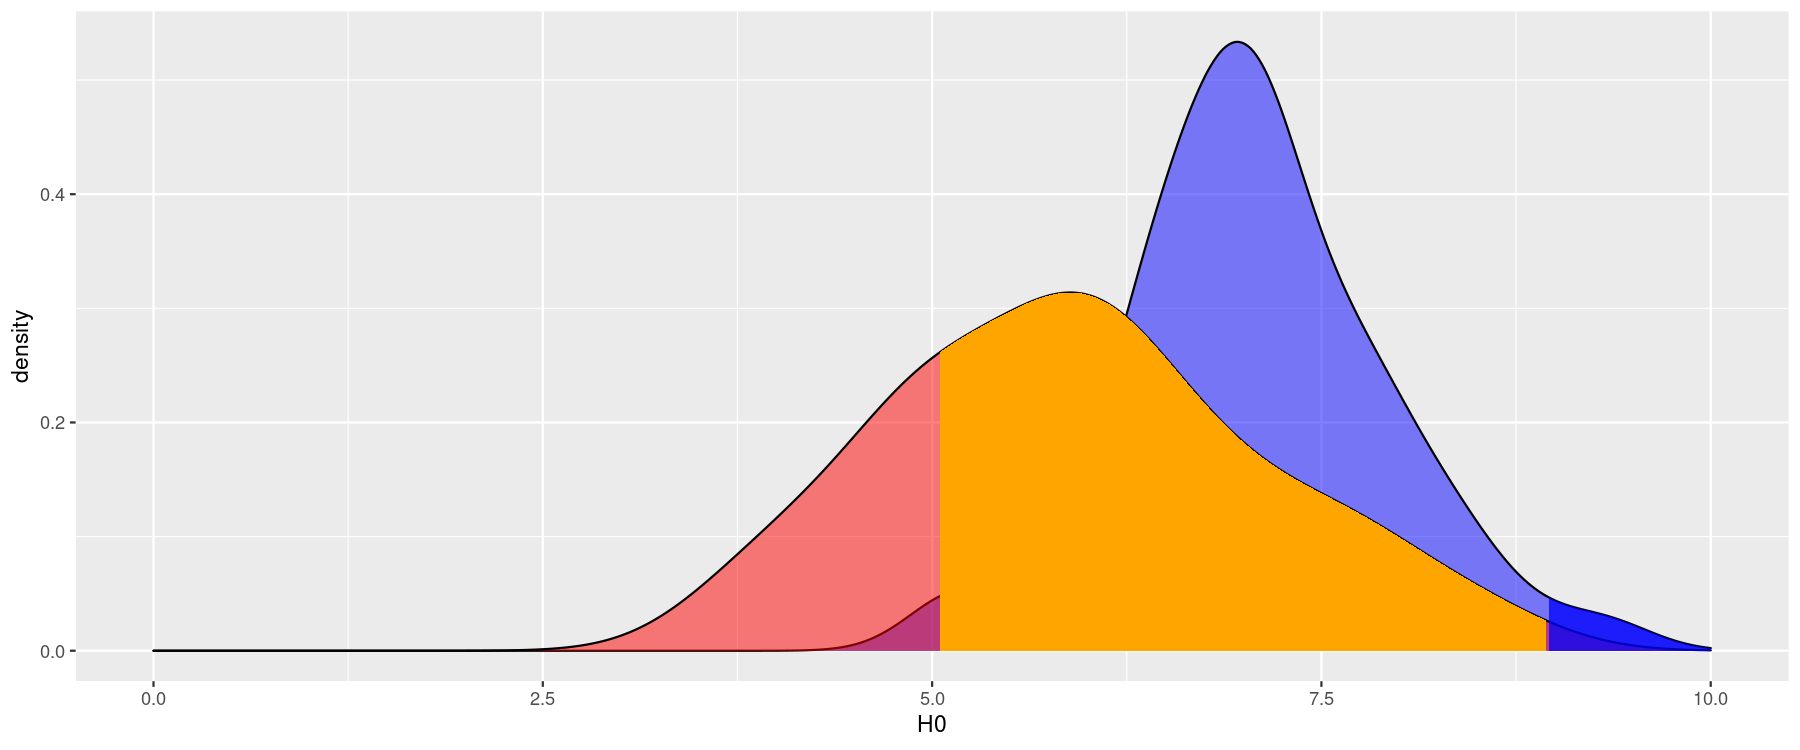

In [266]:
library(tidyverse)
library(scales)

set.seed(100)

sim1 <- rnorm(50, 7, sqrt(1))
sim2 <- rnorm(50, 6, sqrt(1))

alpha1 <- qnorm(0.025, 7, sqrt(1)) 
alpha2 <- qnorm(0.975, 7, sqrt(1))

df_set <- tibble("H0" = sim1, "HA" = sim2)

df_set %>% summary()

ggplot(data = df_set) + geom_density(aes(H0), fill = "blue", alpha = 0.5) + 
                        geom_density(aes(HA), fill = "red", alpha = 0.5) + 
                        geom_area(
                            aes(x = stage(H0, after_scale = oob_censor(x, alpha2
                                                                     )
                                         )
                               ),
                            stat = "density", fill = "blue", alpha = 0.75
                        ) + 
                        geom_area(
                            aes(x = stage(HA, after_scale = oob_censor(x, c(alpha1, alpha2)
                                                                     )
                                         )
                               ),
                            stat = "density", fill = "orange"
                        ) +
                        xlim(0, 10)

In [267]:
alpha

[1] 0.05

       H0               HA       
 Min.   : 3.679   Min.   :2.119  
 1st Qu.: 6.394   1st Qu.:4.319  
 Median : 6.940   Median :5.108  
 Mean   : 6.962   Mean   :5.071  
 3rd Qu.: 7.633   3rd Qu.:5.780  
 Max.   :10.304   Max.   :8.092  

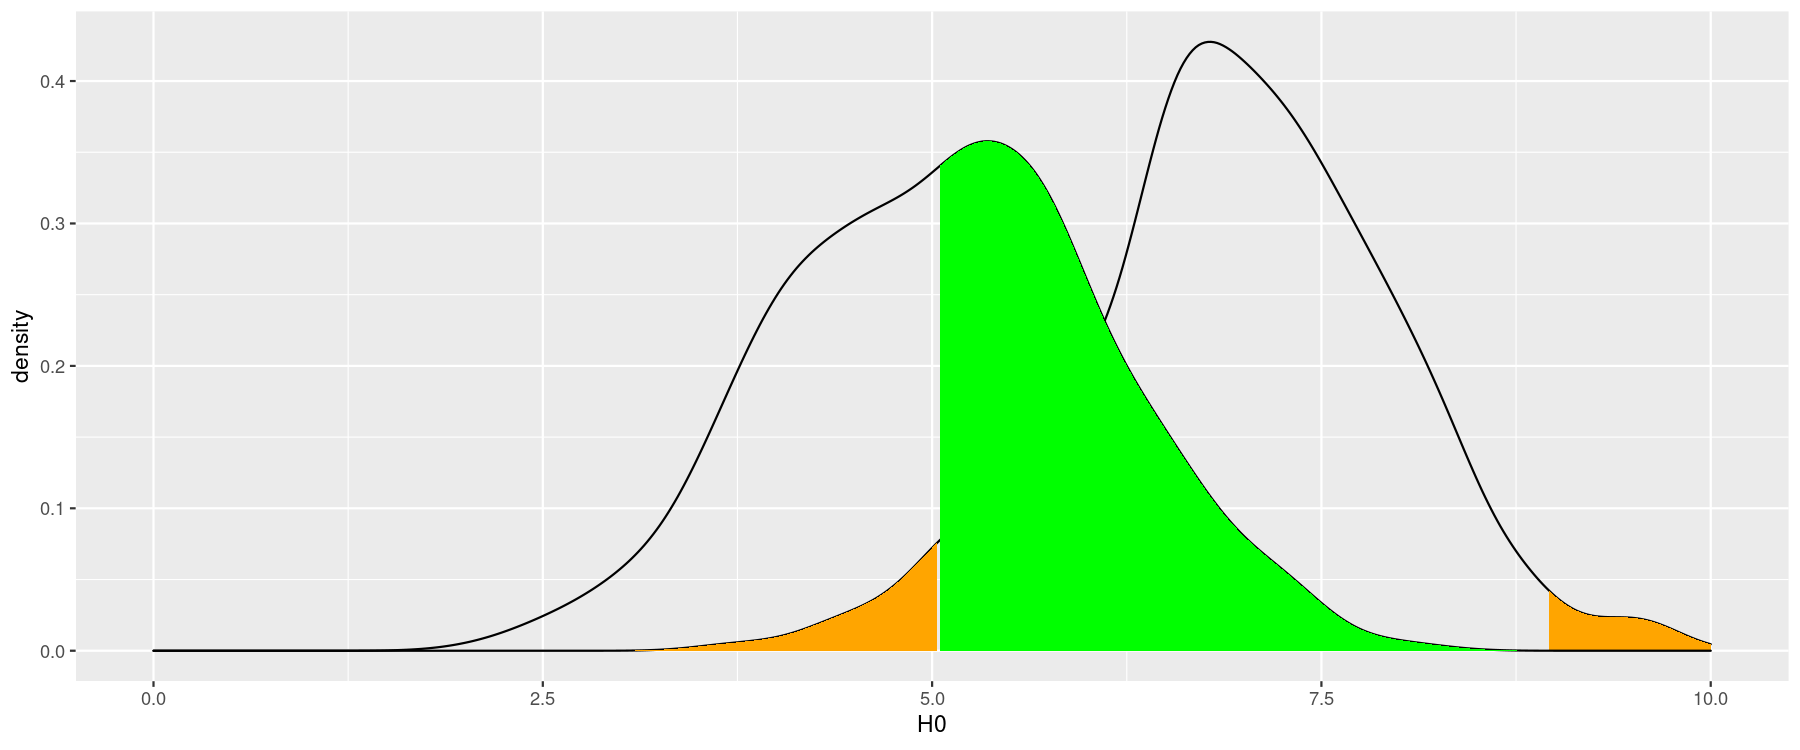

In [268]:
library(tidyverse)
library(scales)

set.seed(100)

sim1 <- rnorm(500, 7, sqrt(1))
sim2 <- rnorm(500, i, sqrt(1))

alpha1 <- qnorm(0.025, 7, sqrt(1)) 
alpha2 <- qnorm(0.975, 7, sqrt(1))

df_set <- tibble("H0" = sim1, "HA" = sim2)

df_set %>% summary()

ggplot(data = df_set) + geom_density(aes(H0), alpha = 0.5) + 
                        geom_area(
                            aes(x = stage(H0, after_scale = oob_censor(x, c(0, alpha1)
                                                                      )
                                         )
                               ),
                            stat = "density", fill = "orange"
                                 ) +
                        geom_area(
                            aes(x = stage(H0, after_scale = oob_censor(x, c(alpha2, Inf)
                                                                      )
                                         )
                               ),
                            stat = "density", fill = "orange"
                                 ) +
                        geom_density(aes(HA), alpha = 0.5) + 
                        geom_area(
                            aes(x = stage(HA, after_scale = oob_censor(x, c(alpha1, alpha2)
                                                                      )
                                         )
                               ),
                            stat = "density", fill = "green"
                                 ) +
                        xlim(0,10)

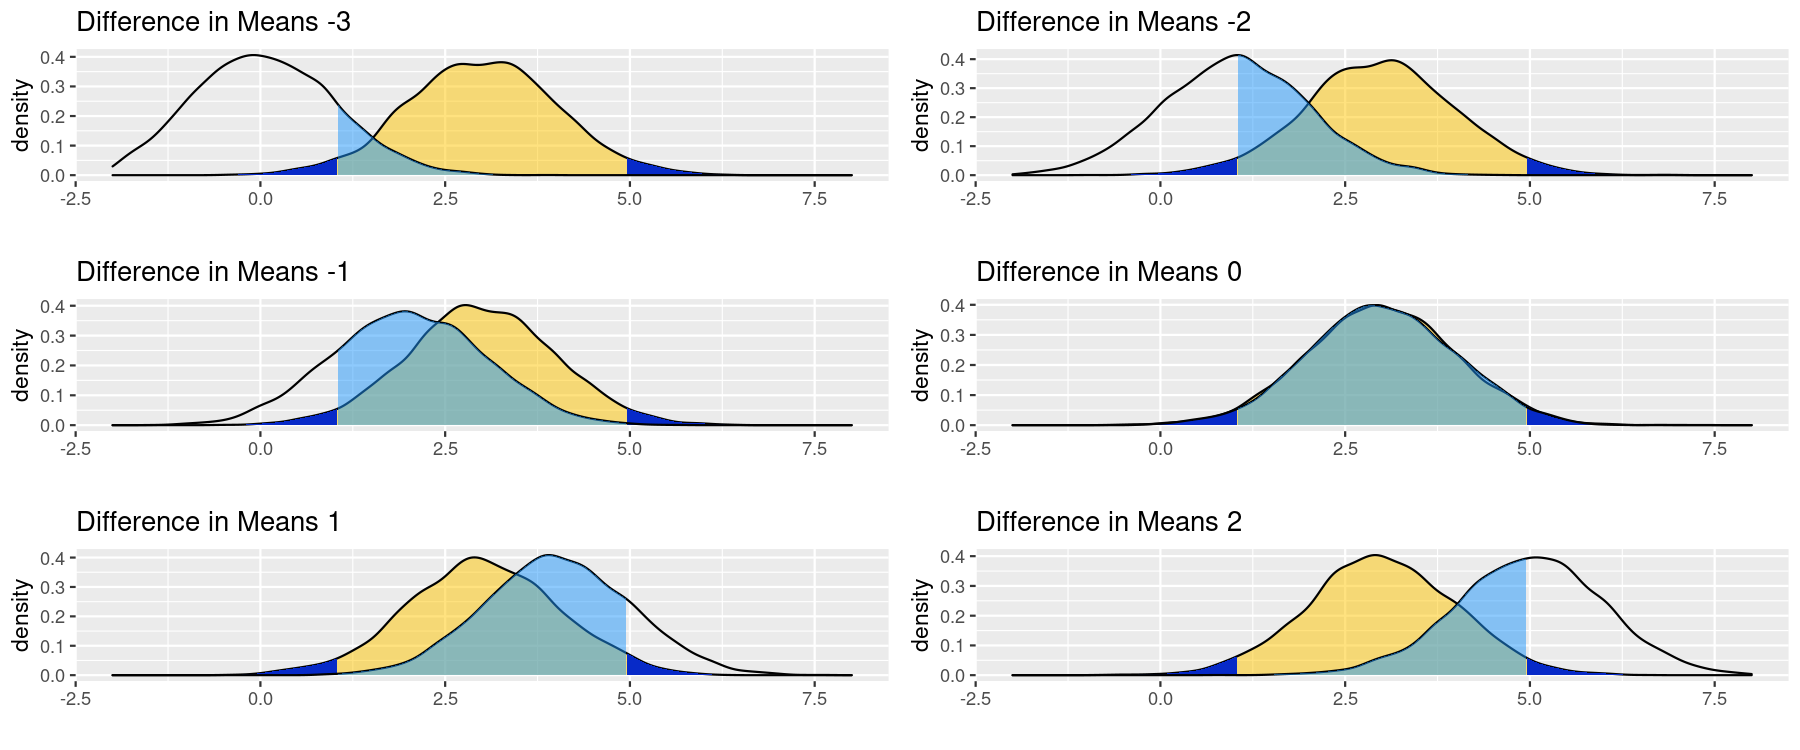

In [334]:
options(warn=-1)

library(gridExtra)

options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 150)
set.seed(100)

null_mean <- 3
alt_means <- c(0, 1, 2, 3, 4, 5)
plot_list <- list()

plot_colors <- c("#072ac8","#1e96fc","#a2d6f9","#fcf300","#ffc600")

for(i in 1:6){
    
    sim1 <- rnorm(5000, null_mean, sqrt(1))
    sim2 <- rnorm(5000, alt_means[i], sqrt(1))

    alpha1 <- qnorm(0.025, null_mean, sqrt(1)) 
    alpha2 <- qnorm(0.975, null_mean, sqrt(1))

    df_set <- tibble("H0" = sim1, "HA" = sim2)
    
    title_string <- sprintf("Difference in Means %i", (alt_means[i] - null_mean))

    plot_list[[i]]  <-
    ggplot(data = df_set) + geom_density(aes(H0), alpha = 0.5, fill = plot_colors[5]) + 
                            geom_area(
                                aes(x = stage(H0, after_scale = oob_censor(x, c(-Inf, alpha1)
                                                                          )
                                             )
                                   ),
                                stat = "density", fill = plot_colors[1]
                                 ) +
                            geom_area(
                                aes(x = stage(H0, after_scale = oob_censor(x, c(alpha2, Inf)
                                                                          )
                                             )
                                   ),
                                stat = "density", fill = plot_colors[1]
                                     ) +
                            geom_density(aes(HA), alpha = 0.5) + 
                            geom_area(
                                aes(x = stage(HA, after_scale = oob_censor(x, c(alpha1, alpha2)
                                                                          )
                                             )
                                   ),
                                stat = "density", fill = plot_colors[2], alpha = 0.5
                                     ) +
                            xlim(-2, 8) + xlab("") + ggtitle(title_string)
    
                                }

do.call(grid.arrange, plot_list)

In [304]:
plot( x = plot_list[1]$data["H0"], y = plot_list[1]$data["HA"])

ERROR: Error in stripchart.default(x1, ...): argument 2 matches multiple formal arguments
